## Waste Classification

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = "DATASET/TRAIN"
test_path = "DATASET/TEST"

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Activation , Dropout , Flatten , Dense , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img
from tensorflow.keras.utils import plot_model
from glob import glob

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [5]:
#Visualization 
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
     for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split('/')[-1])
data = pd.DataFrame({'image': x_data , 'label': y_data})       

100%|██████████| 9999/9999 [00:07<00:00, 1324.23it/s]


In [6]:
data.shape

(22564, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

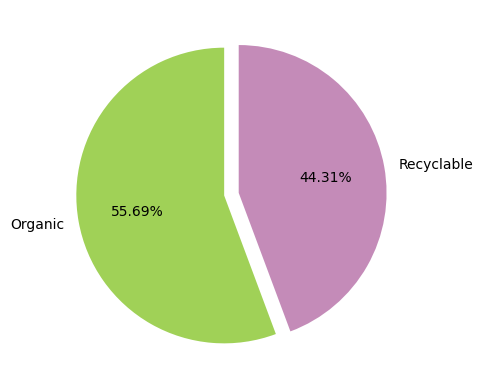

In [7]:
colors = ['#a0d157' , '#c48bb8']
plt.pie(data.label.value_counts() , labels =['Organic' , 'Recyclable'] , autopct='%0.2f%%' , colors=colors , startangle=90 , explode=[0.05 , 0.05])
plt.show

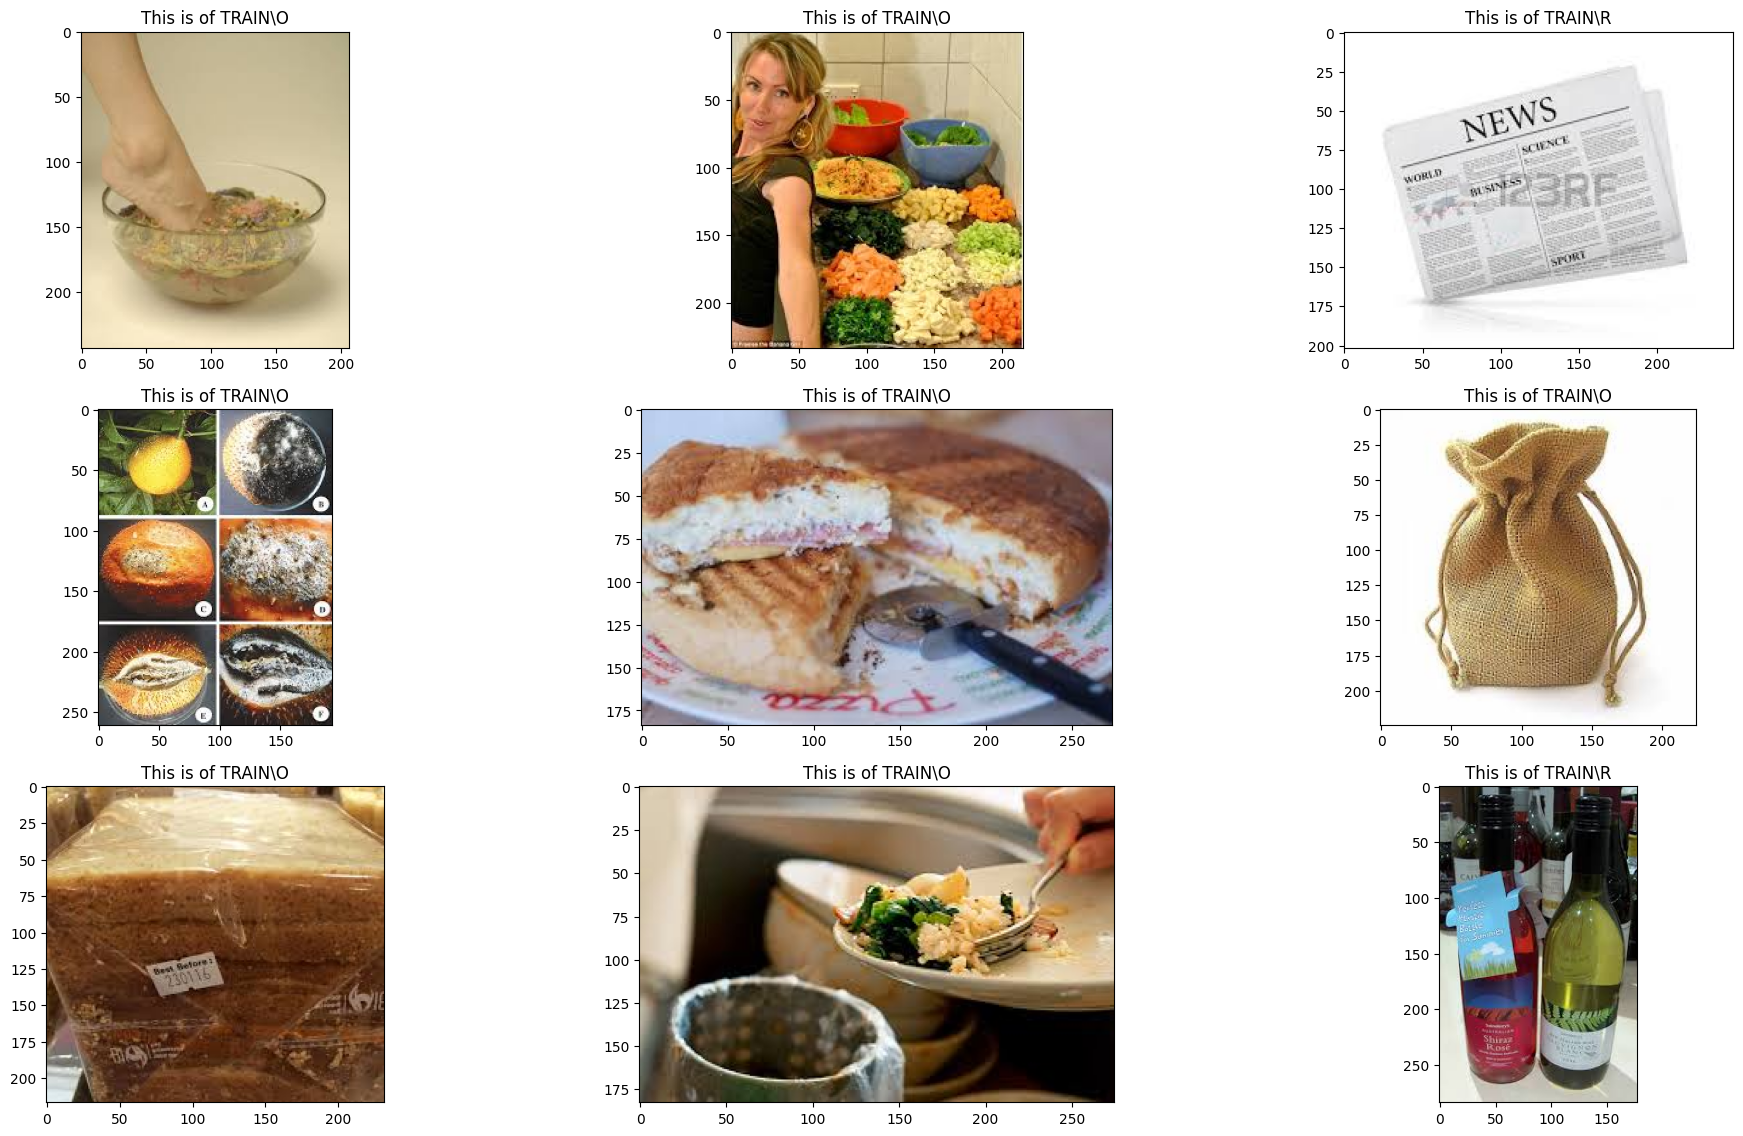

In [8]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3, (i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

## CNN - Convolutional Neural Network

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Freeze base model layers
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
batch_size = 64
target_size = (96, 96)  # Smaller size for faster training

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 96, 96, 3) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Check if train_generator and test_generator are not empty
if train_generator.samples == 0:
    raise ValueError("The training directory is empty or not properly structured. Please check the 'train_path'.")
if test_generator.samples == 0:
    raise ValueError("The testing directory is empty or not properly structured. Please check the 'test_path'.")

# Train the model
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 191s 528ms/step - accuracy: 0.7216 - loss: 0.5919 - val_accuracy: 0.8082 - val_loss: 0.4286
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 186s 528ms/step - accuracy: 0.8576 - loss: 0.3380 - val_accuracy: 0.8197 - val_loss: 0.4051
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 182s 516ms/step - accuracy: 0.8650 - loss: 0.3188 - val_accuracy: 0.8293 - val_loss: 0.3918
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 182s 515ms/step - accuracy: 0.8740 - loss: 0.2933 - val_accuracy: 0.8372 - val_loss: 0.3807
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 181s 513ms/step - accuracy: 0.8835 - loss: 0.2878 - val_accuracy: 0.8376 - val_loss: 0.3726
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 180s 511ms/step - accuracy: 0.8906 - loss: 0.2721 - val_accuracy: 0.8432 - val_loss: 0.3657
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 182s 514ms/step - accuracy: 0.8915 - loss: 0.2701 - val_accuracy: 0.8209 - val_loss: 0.4132
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 181s 513ms/step - accuracy: 0.8939 -

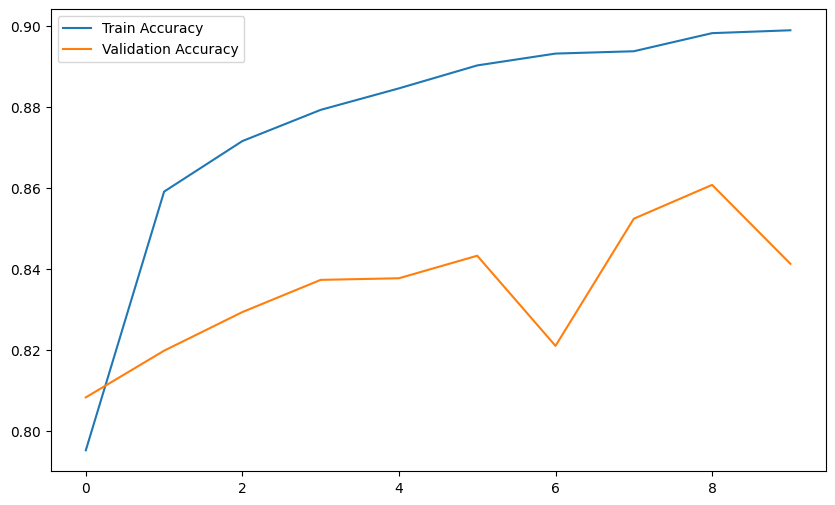

In [13]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'],label='Train Accuracy')
plt.plot(hist.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

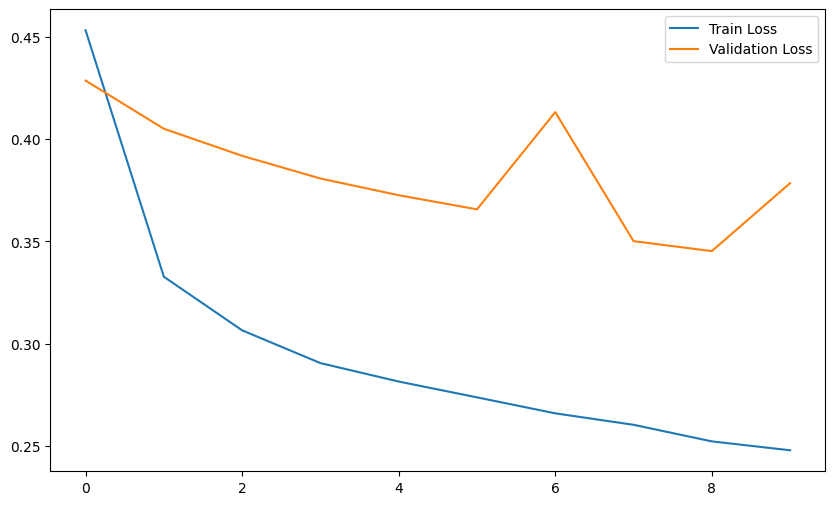

In [14]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'],label='Train Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [26]:
def predict_fun(img):
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    
    img = cv2.resize(img, (96, 96))  # match MobileNetV2 input size
    img = img / 255.0  # normalize as done in training
    img = np.reshape(img, [-1, 96, 96, 3])
    
    result = model.predict(img)[0][0]  # sigmoid output gives value between 0 and 1
    
    if result < 0.5:
        print('The Image Shown is Organic Waste')  # class 0
    else:
        print('The Image Shown is Recyclable Waste')      # class 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
The Image Shown is Recyclable Waste


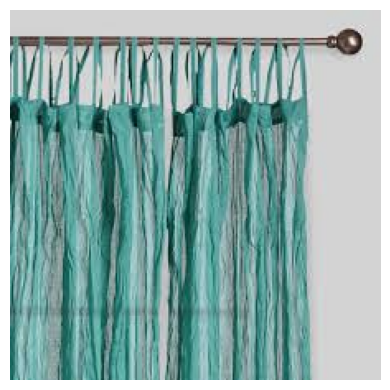

In [33]:
test_img = cv2.imread(r"D:\Prgrms\Vs Code\Waste Classification\DATASET\TEST\R\R_10005.jpg")
predict_fun(test_img)

In [19]:
model.save("waste_classifier_model.keras")